In [1]:
# Breast cancer tissue microarray from Mayerich
# https://stim.ee.uh.edu/resources/data-sets/

# BRC961-BR1001
# The data was shared privately in 2019, The same data seems to be
# available at the web page, but I did not redownload it yet

In [2]:
import dask.array as da
import h5py
import numpy as np
import matplotlib.pyplot as plt


# This dataset could be loadable from its original format. Currently,
# it is not processed efficiently. Either one of the following issues should
# be fixed to support it
# - spectral envi file object does support chunked accesss, but its support
#   does not seem complete enough for dask
# - if dask is given memmap array, it does not perform efficiently

if 0:
    import spectral
    fn = "/home/mtoplak/md/mayerich/brc961-br1001.hdr"
    enf = spectral.io.envi.open(fn)
    x = da.from_array(enf.open_memmap(), chunks=(100, 100, -1))
    print(enf.shape)
    print(x)


In [3]:
%%time

# Conversion from ENVI file into hdf5, which Dask opens efficiently

if 0:
    import spectral
    import h5py
    import numpy as np

    fn = "/home/mtoplak/md/mayerich/brc961-br1001.hdr"
    enf = spectral.io.envi.open(fn)

    lv = enf.metadata["wavelength"]
    features = np.array(list(map(float, lv)))

    ofn = '/home/mtoplak/brc961-br1001.hdf5'
    #ofn = '/home/mtoplak/brc961-br1001-small.hdf5'  # small

    # This conversion is NOT memory efficient (loads the whole array)
    with h5py.File(ofn, 'w') as f:
        f.create_dataset("data", data=enf.open_memmap())
        #f.create_dataset("data", data=enf[:1000,:1000,:])  # small
        f.create_dataset("wavelength", data=features)

#For the whole data set this needed 19min

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 14.1 µs


In [4]:
fn = "/home/mtoplak/brc961-br1001.hdf5"  # 124 GB
#fn = "/home/mtoplak/brc961-br1001-small.hdf5"  # 6.5 GB

f = h5py.File(fn, "r")
data = f["data"]
x = da.from_array(data, chunks=(100, 100, -1))
x = x[:1000, :2000, :]
wns = np.array(f["wavelength"])

print("data size:", x.size*4/1e9, "GB")
print("x:", x)
print("wns:", wns)

data size: 13.008 GB
x: dask.array<getitem, shape=(1000, 2000, 1626), dtype=float32, chunksize=(100, 100, 1626), chunktype=numpy.ndarray>
wns: [ 750.  752.  754. ... 3996. 3998. 4000.]


dask.array<getitem, shape=(1000, 2000), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
CPU times: user 328 ms, sys: 2.64 s, total: 2.96 s
Wall time: 2.88 s


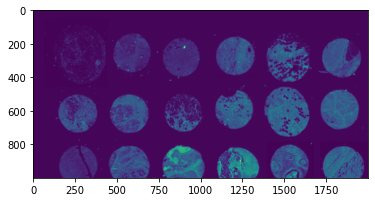

In [5]:
%%time

def nearest_ind(a, v):
    return np.abs(a - v).argmin()

wn1650 = nearest_ind(wns, 1650)

# intensity at 1650
im = x[:, :, wn1650]
print(im)
im_array = im.compute()

plot = plt.imshow(im_array)

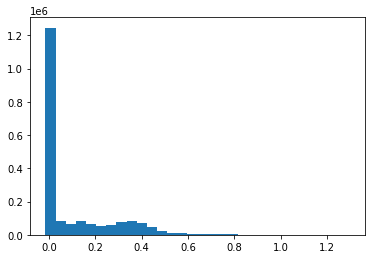

In [6]:
plot = plt.hist(im_array.flatten(), bins=30)

In [7]:
%%time

# Separate voxels with spectral content from the background

non_background = (x[:, :, wn1650] > 0.05)
im_no_background = im.copy()
im_no_background[~non_background] = np.nan

CPU times: user 3.34 ms, sys: 0 ns, total: 3.34 ms
Wall time: 3.35 ms


sample ratio 0.3524075
CPU times: user 794 ms, sys: 5.31 s, total: 6.1 s
Wall time: 5.74 s


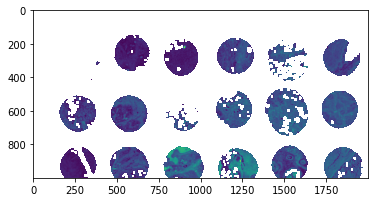

In [8]:
%%time
print("sample ratio", non_background.sum().compute() / (x.shape[0]*x.shape[1]))
plot = plt.imshow(im_no_background.compute())

In [9]:
%%time

# only use 900-1800 spectral region in further analysis

wnc = slice(nearest_ind(wns, 900), nearest_ind(wns, 1800))
x_cut = x[:, :, wnc]
wns_cut = wns[wnc]
print(x_cut)

dask.array<getitem, shape=(1000, 2000, 450), dtype=float32, chunksize=(100, 100, 450), chunktype=numpy.ndarray>
CPU times: user 397 µs, sys: 813 µs, total: 1.21 ms
Wall time: 992 µs


In [10]:
%%time

# PCA on non-backgorund data

def linearize(x):
    if x.ndim == 3:
        return x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    elif x.ndim == 2:
        return x.reshape((x.shape[0] * x.shape[1]))

    
# select non-background data
x_pca = linearize(x_cut)[linearize(non_background)]
print(x_pca)

dask.array<getitem_variadic, shape=(nan, 450), dtype=float32, chunksize=(nan, 450), chunktype=numpy.ndarray>
CPU times: user 12.4 ms, sys: 613 µs, total: 13.1 ms
Wall time: 12.9 ms


In [11]:
%%time

# Incremental PCA needs to know input length
# so dask needs to partially compute
x_pca.compute_chunk_sizes()

CPU times: user 4.74 s, sys: 8.85 s, total: 13.6 s
Wall time: 6.23 s


dask.array<getitem_variadic, shape=(704815, 450), dtype=float32, chunksize=(7179, 450), chunktype=numpy.ndarray>

In [12]:
%%time
import dask_ml.decomposition
pca = dask_ml.decomposition.IncrementalPCA(n_components=20)
pca.fit(x_pca)
print(pca.explained_variance_ratio_)

/local/mtoplak/local/venv38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[8.40866419e-01 1.15935395e-01 2.40181931e-02 7.62373082e-03
 3.88805757e-03 2.15643066e-03 1.21970852e-03 7.13695140e-04
 4.71083277e-04 3.19549497e-04 2.66719300e-04 1.95593191e-04
 1.59204237e-04 1.18401589e-04 8.46215633e-05 3.41595277e-05
 1.62464884e-05 1.02859310e-05 5.57690416e-06 8.75086494e-07]
CPU times: user 23min 2s, sys: 30min 7s, total: 53min 9s
Wall time: 7min 40s


In [13]:
%%time
pca_transform = pca.transform(x_pca)
print(pca_transform)
pca_transform.compute()

dask.array<tensordot, shape=(704815, 20), dtype=float64, chunksize=(7179, 20), chunktype=numpy.ndarray>
CPU times: user 1min 41s, sys: 1min 59s, total: 3min 41s
Wall time: 8.63 s


array([[-1.42083402e+00,  4.17201080e-01,  1.30868067e-01, ...,
         6.83722831e-03, -5.41658921e-03,  2.05788602e-03],
       [-1.16262187e+00,  9.56569631e-01, -2.65237146e-01, ...,
         3.84663888e-03,  8.10814699e-03,  1.43688517e-02],
       [-9.26447303e-01,  1.12883242e+00, -2.84649216e-01, ...,
        -4.10259282e-04,  5.79867945e-03,  7.56547544e-03],
       ...,
       [-1.53635842e-01,  2.77419972e-01,  1.90342559e-01, ...,
         8.61662559e-03, -8.85769813e-03, -7.20690314e-07],
       [-7.13629055e-01,  2.55989410e-01,  1.47677011e-01, ...,
         1.98906465e-03, -7.60196690e-03,  2.28151283e-04],
       [-1.46297628e+00,  2.73085167e-01,  7.27105621e-02, ...,
         7.32617082e-03, -4.12541917e-03,  3.43823565e-04]])

In [14]:
%%time

pca_transform = pca.transform(x_pca)  # no immediate action
print("pca transform:", pca_transform)

pca transform: dask.array<tensordot, shape=(704815, 20), dtype=float64, chunksize=(7179, 20), chunktype=numpy.ndarray>
CPU times: user 4.98 ms, sys: 1.01 ms, total: 6 ms
Wall time: 5.62 ms


In [15]:
# If Dask supported nice indexing for setting this this would
# work well. Now we'd need to workaround it, unfortunatelly.

pca_scores = da.full(x.shape[:2] + (20,), np.nan)

# The following does not work because setitem is currently limited 
# to 1D arrays in dask
pca_scores[non_background] = pca_transform

ValueError: boolean index array should have 1 dimension

In [16]:
%%time

# Create PCA scores in numpy instead of disk
# The same code as in the cell above but in numpy
# (see the .compute() calls)

pca_scores = np.full(x.shape[:2] + (20,), np.nan)
pca_scores[non_background.compute()] = pca_transform.compute()

CPU times: user 1min 33s, sys: 1min 49s, total: 3min 22s
Wall time: 11.1 s


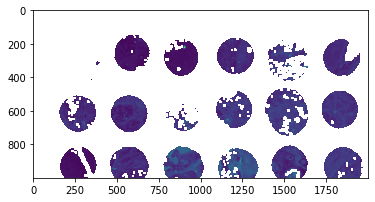

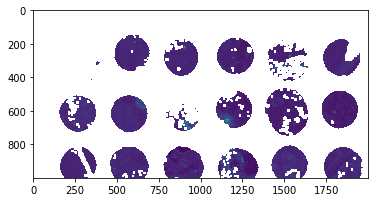

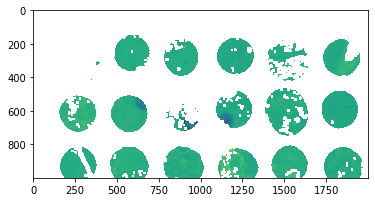

In [17]:
for i in range(3):
    plot = plt.imshow(pca_scores[..., i])
    plt.show()